リクエストがあったので、最後にRNASeq解析を取り上げることとしました。<br>
論文で見る「遺伝子発現差解析」では、Rパッケージの`DESeq2`がよく使われています。<br>
<br>
素直にRを使うほうが圧倒的に簡単なのですが、今回はPythonでやってみたいと思います。<br>
<br>
使用するのは、`DESeq2`をPythonで作り直した、`PyDESeq2`パッケージです。<br>
<br>

---

## 参考サイト
- [RNA-seq workflow: gene-level exploratory analysis and differential expression](https://bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html)
- [PyDESeq2 - Getting Started](https://pydeseq2.readthedocs.io/en/latest/auto_examples/index.html)

---

## 使用データ
### Sample情報
```
mRNA profiles obtained via RNA-Seq for four primary human airway smooth muscle cell lines
that were treated with dexamethasone, albuterol, dexamethasone+albuterol or were left untreated.
```
↓
```
デキサメタゾン、アルブテロール、デキサメタゾン＋アルブテロールで処理した、
あるいは未処理の4つの初代ヒト気道平滑筋細胞株について、RNA-Seqで得られたmRNAプロファイル。
```
※ 今回は、未処理 vs デキサメタゾン の各4サンプル

### Cite
Himes BE, Jiang X, Wagner P, Hu R, Wang Q, Klanderman B, Whitaker RM, Duan Q, Lasky-Su J, Nikolos C, Jester W, Johnson M, Panettieri RA Jr, Tantisira KG, Weiss ST, Lu Q. RNA-Seq transcriptome profiling identifies CRISPLD2 as a glucocorticoid responsive gene that modulates cytokine function in airway smooth muscle cells. PLoS One. 2014 Jun 13;9(6):e99625. doi: 10.1371/journal.pone.0099625. PMID: 24926665; PMCID: PMC4057123.

---

## 注意点
Pythonでの解析の流れを体験していただくことを目的に取り上げさせて頂きました。<br>
実際に初めてRNASeq解析をする場合は、情報の多い “Rパッケージの`DESeq2`” を使用することを強くオススメします。<br>
<br>
また、使用するツールやフィルタリングの方法、正規化の手法などで結果が変わることが知られています。<br>
ここで取り上げたことを鵜呑みにせず、様々な文献・書籍で確認してから実際の解析をしてください。

In [1]:
!pip install pydeseq2 -q

In [2]:
import pandas as pd
import numpy as np
import pydeseq2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE52778

# https://www.ncbi.nlm.nih.gov/geo/download/?type=rnaseq_counts&acc=GSE52778&format=file&file=GSE52778_raw_counts_GRCh38.p13_NCBI.tsv.gz

In [4]:
counts = pd.read_csv("../data/csv/rnaseq_GSE52778_counts.csv", index_col=0)
counts = counts.T
counts

Gene,DDX11L1,WASH7P,MIR6859-1,MIR1302-2HG,MIR1302-2,FAM138A,OR4F5,LOC100996442,LOC729737,DDX11L17,...,ND4,TRNH,TRNS2,TRNL2,ND5,ND6,TRNE,CYTB,TRNT,TRNP
N61311_Dex,8,292,11,1,0,2,0,22,38,10,...,69611,90,101,109,46762,19689,860,48921,84,348
N052611_Dex,10,428,15,2,0,2,0,41,124,15,...,181386,126,157,193,130853,59619,2688,137684,278,972
N080611_Dex,8,415,11,1,0,2,0,27,56,12,...,105655,144,185,158,123636,44255,2786,98662,170,998
N061011_Dex,1,381,9,1,0,3,0,35,70,1,...,121719,70,93,85,89982,32536,1780,84954,121,772
N61311_untreated,6,357,12,1,0,7,0,24,50,8,...,65368,51,60,70,45878,17596,739,44146,79,290
N052611_untreated,5,469,15,3,0,6,0,46,118,7,...,102257,86,121,116,81923,30975,1874,63746,174,795
N080611_untreated,6,367,9,1,0,2,0,27,43,7,...,111873,108,132,126,105695,40220,2391,88078,176,991
N061011_untreated,2,371,10,2,0,6,0,57,78,2,...,103769,71,78,82,73708,29123,1516,65091,113,693


In [5]:
metadata = pd.read_csv("../data/csv/rnaseq_GSE52778_metadata.csv", index_col=0)
metadata

,treatment,cell_line
title,,
N61311_Dex,Dex,N61311
N052611_Dex,Dex,N052611
N080611_Dex,Dex,N080611
N061011_Dex,Dex,N061011
N61311_untreated,untreated,N61311
N052611_untreated,untreated,N052611
N080611_untreated,untreated,N080611
N061011_untreated,untreated,N061011


# PyDESeq2

In [6]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [7]:
genes_to_keep = counts.columns[counts.sum(axis=0) >= 20]
genes_to_keep

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'FAM138A', 'LOC100996442',
       'LOC729737', 'DDX11L17', 'WASH9P', 'MIR6859-2', 'LOC107985721',
       ...
       'ND4', 'TRNH', 'TRNS2', 'TRNL2', 'ND5', 'ND6', 'TRNE', 'CYTB', 'TRNT',
       'TRNP'],
      dtype='object', name='Gene', length=20080)

In [8]:
counts = counts[genes_to_keep]
counts

Gene,DDX11L1,WASH7P,MIR6859-1,FAM138A,LOC100996442,LOC729737,DDX11L17,WASH9P,MIR6859-2,LOC107985721,...,ND4,TRNH,TRNS2,TRNL2,ND5,ND6,TRNE,CYTB,TRNT,TRNP
N61311_Dex,8,292,11,2,22,38,10,330,10,2,...,69611,90,101,109,46762,19689,860,48921,84,348
N052611_Dex,10,428,15,2,41,124,15,470,12,2,...,181386,126,157,193,130853,59619,2688,137684,278,972
N080611_Dex,8,415,11,2,27,56,12,509,9,2,...,105655,144,185,158,123636,44255,2786,98662,170,998
N061011_Dex,1,381,9,3,35,70,1,389,12,1,...,121719,70,93,85,89982,32536,1780,84954,121,772
N61311_untreated,6,357,12,7,24,50,8,378,14,2,...,65368,51,60,70,45878,17596,739,44146,79,290
N052611_untreated,5,469,15,6,46,118,7,502,11,4,...,102257,86,121,116,81923,30975,1874,63746,174,795
N080611_untreated,6,367,9,2,27,43,7,453,7,4,...,111873,108,132,126,105695,40220,2391,88078,176,991
N061011_untreated,2,371,10,6,57,78,2,382,7,3,...,103769,71,78,82,73708,29123,1516,65091,113,693


In [9]:
inference = DefaultInference(n_cpus=4)
dds = DeseqDataSet(
    counts=counts,
    metadata=metadata,
    design_factors="treatment",
    refit_cooks=True,
    inference=inference,
)

In [10]:
# deseq2を実行
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.47 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 3.24 seconds.

Fitting LFCs...
... done in 1.40 seconds.

Refitting 0 outliers.



In [11]:
print(dds)

AnnData object with n_obs × n_vars = 8 × 20080
    obs: 'treatment', 'cell_line'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'


In [12]:
# Wald検定を取り、結果を表示する。
stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: treatment untreated vs Dex
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gene                                                                       
DDX11L1           6.019104       -0.385183  0.816741 -0.471610  0.637205   
WASH7P          385.930267        0.203887  0.186579  1.092765  0.274497   
MIR6859-1        11.737765        0.155619  0.477154  0.326141  0.744318   
FAM138A           3.909364        1.403427  0.823962  1.703266  0.088518   
LOC100996442     34.139648        0.448543  0.315266  1.422744  0.154810   
...                    ...             ...       ...       ...       ...   
ND6           32805.936165       -0.214947  0.247741 -0.867628  0.385598   
TRNE           1746.568964       -0.127113  0.325100 -0.390996  0.695800   
CYTB          75613.870947       -0.312548  0.205643 -1.519853  0.128548   
TRNT            143.933268       -0.065257  0.326482 -0.199878  0.841576   
TRNP            701.002

... done in 0.55 seconds.



In [13]:
# 結果をデータフレームとして取得
deseq_result_df = stat_res.results_df
deseq_result_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
DDX11L1,6.019104,-0.385183,0.816741,-0.471610,0.637205,0.837702
WASH7P,385.930267,0.203887,0.186579,1.092765,0.274497,0.540109
MIR6859-1,11.737765,0.155619,0.477154,0.326141,0.744318,0.897181
FAM138A,3.909364,1.403427,0.823962,1.703266,0.088518,NaN
LOC100996442,34.139648,0.448543,0.315266,1.422744,0.154810,0.384505
...,...,...,...,...,...,...
ND6,32805.936165,-0.214947,0.247741,-0.867628,0.385598,0.651973
TRNE,1746.568964,-0.127113,0.325100,-0.390996,0.695800,0.870271
CYTB,75613.870947,-0.312548,0.205643,-1.519853,0.128548,0.341391


| 表示 | 詳細 |
| :---: | --- |
| baseMean | 平均発現量 |
| log2FoldChange | FoldChange(Target vs Controlの比)をlog2で対数を取った値<br>+だとTarget群で多い。-だとControl群で多い |
| lfcSE | log2FCの標準誤差 |
| stat | Wald検定の統計量 |
| pvalue | Wald検定で算出されたp値 |
| padj | p値を多重比較の誤りを考慮して補正された後の値 |

In [14]:
deseq_result_df["log10(padj)"] = -np.log10(deseq_result_df["padj"])

color_list = []
for i in range(deseq_result_df.shape[0]):
    _padj = deseq_result_df["padj"].values[i]
    _fc = deseq_result_df["log2FoldChange"].values[i]

    if _padj < 0.05:
        if _fc > 0:
            color_list.append("untreatment_up")
        else:
            color_list.append("Dex_up")
    else:
        color_list.append("ns")

deseq_result_df["color"] = color_list
deseq_result_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10(padj),color
Gene,,,,,,,,
DDX11L1,6.019104,-0.385183,0.816741,-0.471610,0.637205,0.837702,0.076911,ns
WASH7P,385.930267,0.203887,0.186579,1.092765,0.274497,0.540109,0.267518,ns
MIR6859-1,11.737765,0.155619,0.477154,0.326141,0.744318,0.897181,0.047120,ns
FAM138A,3.909364,1.403427,0.823962,1.703266,0.088518,NaN,NaN,ns
LOC100996442,34.139648,0.448543,0.315266,1.422744,0.154810,0.384505,0.415098,ns
...,...,...,...,...,...,...,...,...
ND6,32805.936165,-0.214947,0.247741,-0.867628,0.385598,0.651973,0.185771,ns
TRNE,1746.568964,-0.127113,0.325100,-0.390996,0.695800,0.870271,0.060345,ns
CYTB,75613.870947,-0.312548,0.205643,-1.519853,0.128548,0.341391,0.466748,ns


In [15]:
deseq_result_df.loc[["MDK"]]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10(padj),color
Gene,,,,,,,,
MDK,2010.873753,0.4755,0.15476,3.072506,0.002123,0.016169,1.791323,untreatment_up


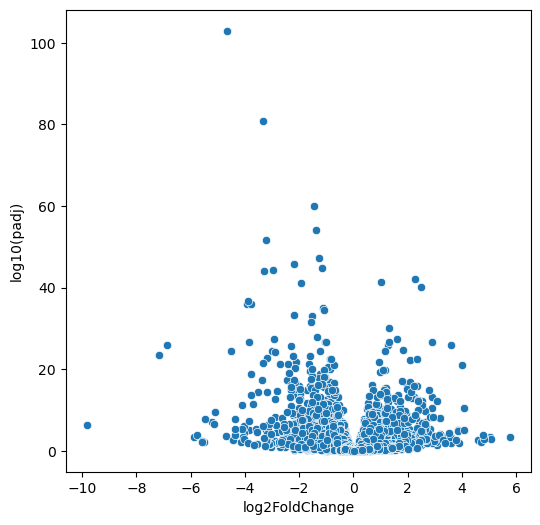

In [25]:
# キャンバスを作成
fig, ax = plt.subplots(figsize=(6, 6))

# 散布図を作成
sns.scatterplot(
    data=deseq_result_df,
    x="log2FoldChange",
    y="log10(padj)",
    ax=ax
)

# 上記の設定を反映したグラフを表示
plt.show()

`color`列を使って色をつけてみる

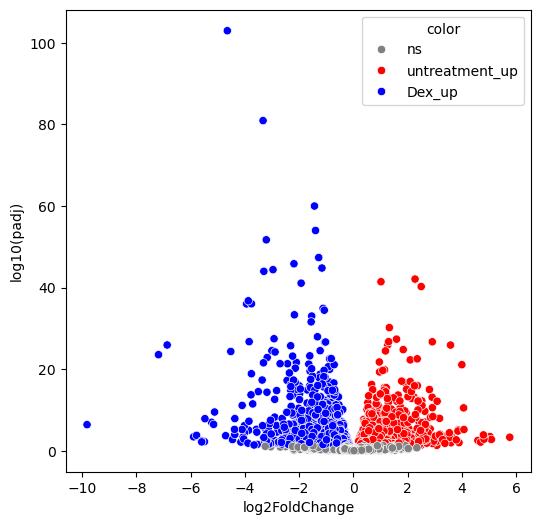

In [28]:
color_dict = {"untreatment_up": "red", "Dex_up": "blue", "ns": "gray"}

# キャンバスを作成
fig, ax = plt.subplots(figsize=(6, 6))

# 散布図を作成
sns.scatterplot(
    data=deseq_result_df,
    x="log2FoldChange",
    y="log10(padj)",
    hue="color",
    palette=color_dict,
    ax=ax
)

# 上記の設定を反映したグラフを表示
plt.show()

`alpha`で透過。`size`も指定。

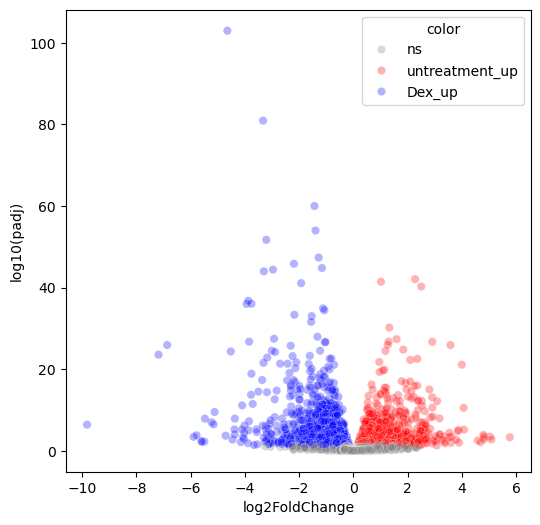

In [32]:
# キャンバスを作成
fig, ax = plt.subplots(figsize=(6, 6))

# 散布図を作成
sns.scatterplot(
    data=deseq_result_df,
    x="log2FoldChange",
    y="log10(padj)",
    hue="color",
    alpha=0.3,
    palette=color_dict,
    ax=ax
)

# 上記の設定を反映したグラフを表示
plt.show()

`set_xlim()`でx軸に制限をつけて、左右対称にしてみる

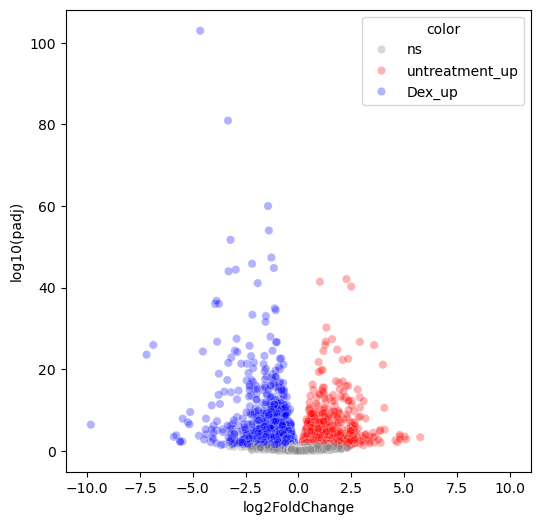

In [33]:
# キャンバスを作成
fig, ax = plt.subplots(figsize=(6, 6))

# 散布図を作成
sns.scatterplot(
    data=deseq_result_df,
    x="log2FoldChange",
    y="log10(padj)",
    hue="color",
    alpha=0.3,
    palette=color_dict,
    ax=ax
)

ax.set_xlim(-11, 11)

# 上記の設定を反映したグラフを表示
plt.show()

DESeq2では、「取得リード数のバラバラで、横に比較のできないRNASeqリードデータ」を正規化してくれます。<br>
そのデータの取得をしてみます。<br>
<br>
pandasよりも高次元のデータを保持できる、`anndata`形式に入っています。<br>
`anndata`については、難しすぎるので割愛します。<br>
(`pandas`や`dict`形式について理解できていれば、すんなり使えるようになるかもしれません。<br>
興味のある方は、`scanpy`を使った single cell RNA-Seqに挑戦してみてください。)

In [18]:
normed_counts = pd.DataFrame(dds.layers["normed_counts"], index=dds.obs.index, columns=dds.var.index)
normed_counts["treatment"] = normed_counts.index.map(lambda x: x.split("_")[-1])
normed_counts

Gene,DDX11L1,WASH7P,MIR6859-1,FAM138A,LOC100996442,LOC729737,DDX11L17,WASH9P,MIR6859-2,LOC107985721,...,TRNH,TRNS2,TRNL2,ND5,ND6,TRNE,CYTB,TRNT,TRNP,treatment
title,,,,,,,,,,,,,,,,,,,,,
N61311_Dex,11.512003,420.188096,15.829004,2.878001,31.658007,54.682013,14.390003,474.870109,14.390003,2.878001,...,129.510030,145.339033,156.851036,67290.533402,28332.477485,1237.540283,70397.335113,120.876028,500.772115,Dex
N052611_Dex,7.720419,330.433916,11.580628,1.544084,31.653716,95.733191,11.580628,362.859674,9.264502,1.544084,...,97.277274,121.210572,149.004079,101023.993536,46028.363665,2075.248520,106297.811483,214.627637,750.424688,Dex
N080611_Dex,7.367317,382.179573,10.130061,1.841829,24.864695,51.571220,11.050976,468.745549,8.288232,1.841829,...,132.611707,170.369207,145.504512,113858.201686,40755.077126,2565.668170,90859.279617,156.555488,919.072805,Dex
N061011_Dex,0.794960,302.879577,7.154636,2.384879,27.823583,55.647166,0.794960,309.239253,9.539514,0.794960,...,55.647166,73.931235,67.571559,71532.047573,25864.802959,1415.027946,67534.991104,96.190102,613.708750,Dex
N61311_untreated,7.601934,452.315096,15.203869,8.868923,30.407738,63.349453,10.135913,478.921866,17.737847,2.533978,...,64.616442,76.019344,88.689235,58126.924314,22293.939584,936.304919,55932.499254,100.092136,367.426829,untreated
N052611_untreated,5.432130,509.533756,16.296389,6.518556,49.975592,128.198258,7.604981,545.385811,11.950685,4.345704,...,93.432629,131.457536,126.025407,89003.270515,33652.042823,2035.962171,69255.306595,189.038110,863.708605,untreated
N080611_untreated,5.975087,365.476142,8.962630,1.991696,26.887891,42.821455,6.970935,451.119053,6.970935,3.983391,...,107.551562,131.451909,125.476823,105256.133131,40052.998482,2381.072088,87712.282454,175.269213,986.885169,untreated
N061011_untreated,1.748981,324.435980,8.744905,5.246943,49.845959,68.210260,1.748981,334.055376,6.121434,2.623472,...,62.088826,68.210260,71.708222,64456.946704,25467.787199,1325.727617,56921.461957,98.817428,606.021925,untreated


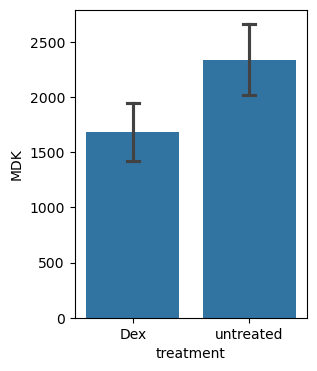

In [19]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.barplot(data=normed_counts, x="treatment", y="MDK", ci="sd", capsize=0.1, ax=ax)
plt.show()

In [20]:
significant_df = deseq_result_df[deseq_result_df["padj"] < 0.05]
significant_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10(padj),color
Gene,,,,,,,,
LINC02593,15.733398,2.015446,0.539813,3.733602,1.887606e-04,2.222238e-03,2.653209,untreatment_up
LOC107985728,20.878509,2.622127,0.568593,4.611603,3.995749e-06,7.992824e-05,4.097300,untreatment_up
CCNL2,5363.128563,-0.299325,0.095881,-3.121842,1.797233e-03,1.417330e-02,1.848529,Dex_up
SLC35E2B,2862.231674,0.446310,0.133989,3.330938,8.655376e-04,7.843543e-03,2.105488,untreatment_up
SLC35E2A,1793.805232,0.427347,0.159886,2.672829,7.521468e-03,4.353736e-02,1.361138,untreatment_up
...,...,...,...,...,...,...,...,...
ZFP92,41.730121,-1.617609,0.494927,-3.268381,1.081645e-03,9.458118e-03,2.024195,Dex_up
MECP2,2266.309085,-0.308519,0.103842,-2.971036,2.967966e-03,2.118821e-02,1.673906,Dex_up
FLNA,93350.295217,-0.587286,0.150480,-3.902756,9.510362e-05,1.241703e-03,2.905982,Dex_up
